Cox Model Summary:
                                    coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                       
age                             0.147508   1.158943  0.053509        0.042632   
extraversion                    0.039064   1.039837  0.068742       -0.095668   
independ                       -0.031366   0.969121  0.065483       -0.159710   
selfcontrol                    -0.059168   0.942548  0.068093       -0.192628   
anxiety                        -0.080695   0.922475  0.063794       -0.205730   
gender_f                        0.043907   1.044885  0.239306       -0.425125   
gender_m                       -0.043907   0.957043  0.239306       -0.512939   
industry_ HoReCa                0.015192   1.015308  0.056400       -0.095350   
industry_Agriculture            0.060472   1.062338  0.058199       -0.053596   
industry_Banks                  0.146325   1.157572  0.114628       -0.078342   
industry_

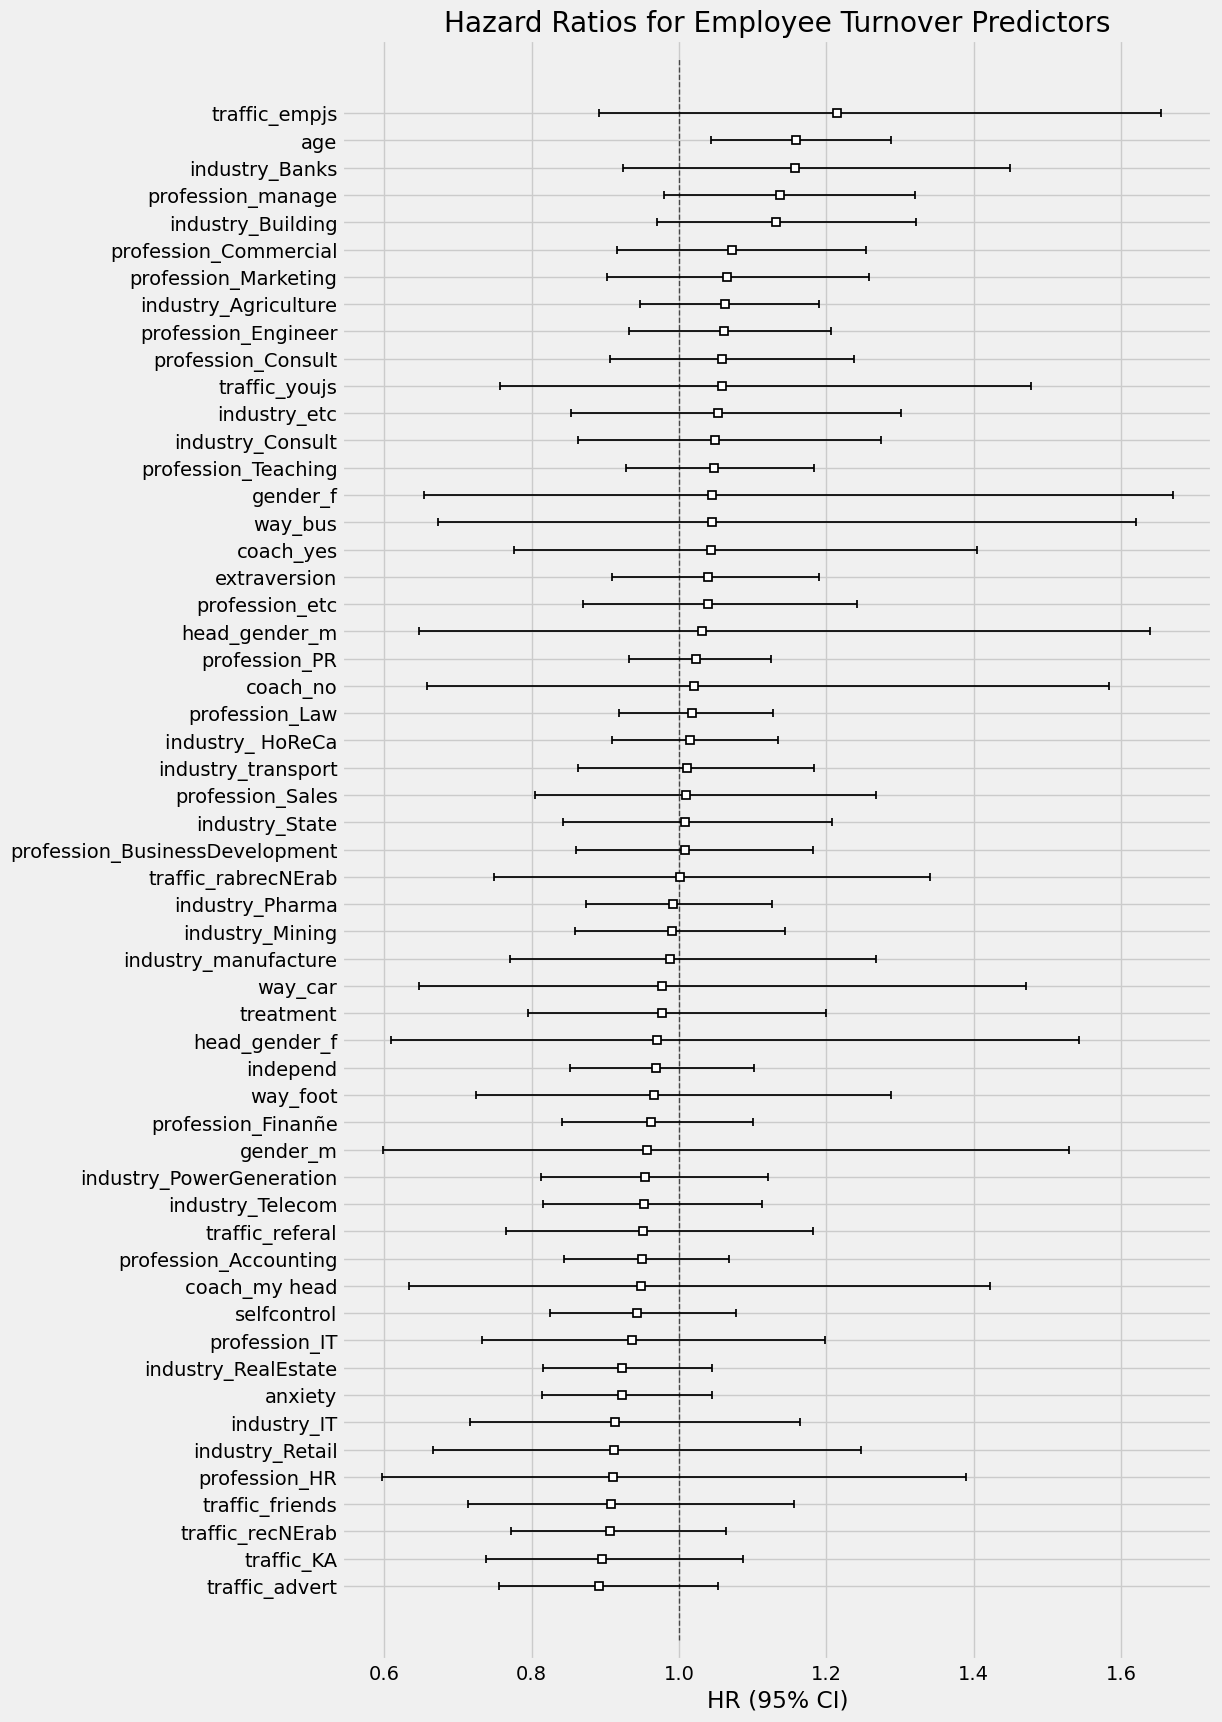

In [3]:
import pandas as pd
import numpy as np

from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

from causalml.inference.meta import BaseXClassifier
from causalml.metrics import auuc_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

# Load dataset and data dictionary
df = pd.read_csv("./data/turnover.csv", encoding='latin-1').drop(["greywage", "novator"], axis=1)

# Preprocessing based on data dictionary
# Convert categorical features
categorical_cols = ['gender', 'industry', 'profession', 'traffic', 'head_gender', 'way', 'coach']
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(df[categorical_cols])

# Create a DataFrame with the encoded data and appropriate column names
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)

# Drop original categorical columns and concatenate the encoded columns
df = df.drop(columns=categorical_cols)
df = pd.concat([df, encoded_df], axis=1)

# Create synthetic treatment variable (30% of employees receive intervention)
np.random.seed(42)
df['strata'] = pd.qcut(df['extraversion'], q=4, labels=False)
df['treatment'] = df.groupby('strata')['strata'].transform(
    lambda x: np.random.choice([0,1], size=len(x), p=[0.7,0.3])
)

# Prepare survival analysis variables
df.rename(columns={'stag': 'tenure'}, inplace=True)
df['event'] = df['event'].astype(int)

# Feature scaling
scaler = StandardScaler()
features = ['age', 'extraversion', 'independ', 'selfcontrol', 'anxiety'] + list(encoded_df.columns)
df[features] = scaler.fit_transform(df[features])

# Split data
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Uplift modeling with corrected learner types
uplift_model = BaseXClassifier(
    control_outcome_learner=RandomForestClassifier(n_estimators=100, random_state=42),
    treatment_outcome_learner=RandomForestClassifier(n_estimators=100, random_state=42),
    control_effect_learner=RandomForestRegressor(n_estimators=100, random_state=42),
    treatment_effect_learner=RandomForestRegressor(n_estimators=100, random_state=42),
    control_name=0,
)

# 1. Calculate propensity scores
propensity_model = LogisticRegression(max_iter=1000, random_state=42)

# Use original training features (before preprocessing)
propensity_features = train.drop(['treatment', 'event', 'tenure'], axis=1)
propensity_model.fit(propensity_features, train['treatment'])

# Get propensity scores from ORIGINAL features
train_propensity = propensity_model.predict_proba(propensity_features)[:, 1]

# 2. Pass propensity scores to fit()
uplift_model.fit(
    X=train,
    treatment=train['treatment'],
    y=train['event'],
    p=train_propensity  # Explicit propensity scores
)


# 3. Calculate test propensity scores
test_propensity = propensity_model.predict_proba(
    test.drop(['treatment', 'event', 'tenure'], axis=1)
)[:, 1]

# Add uplift to TRAIN data
train['uplift'] = uplift_model.predict(
    X=train,
    p=train_propensity  # Use training propensity scores
)

# # 4. Predict with test features and propensity scores
# test['uplift'] = uplift_model.predict(
#     X=test,
#     p=test_propensity
# )

# Survival analysis with Cox model
cph_features = features + ['treatment']

cph = CoxPHFitter(penalizer=0.01)
cph.fit(train[cph_features + ['tenure', 'event']], 
        duration_col='tenure', 
        event_col='event')

# Results summary
print("Cox Model Summary:")
print(cph.summary)
print(f"\nConcordance Index: {cph.concordance_index_:.3f}")

# Visualize feature impacts
plt.figure(figsize=(10, 20))
cph.plot(hazard_ratios=True)
plt.title('Hazard Ratios for Employee Turnover Predictors')
plt.show()

In [ ]:
x